## System Configuration

**Instance**: Lambda Labs `gpu_1x_gh200`  
**OS**: Ubuntu 22.04.5 LTS (ARM64)  
**Kernel**: Linux 6.8.0-1013-nvidia-64k  
**Kubernetes**: MicroK8s v1.32.3  

### GPU Setup
- **GPU**: NVIDIA GH200 480GB (Grace Hopper)
- **Driver**: 570.124.06
- **Total VRAM**: 97,871 MiB (~95.6 GB)
- **MIG Config**: 3x `nvidia.com/mig-2g.24gb` devices (24GB each)

### Model Deployment  
- **Model**: TinyLLaMA-1.1B-Chat-v1.0
- **Engine**: vLLM (`substratusai/vllm-gh200:v0.8.3`)
- **Replicas**: 3 pods, each isolated on separate MIG device
- **K8s Plugin**: nvidia/k8s-device-plugin:v0.17.1 (`--mig-strategy=mixed`)
- Custom config for VTC:
  -  `AIBRIX_ROUTER_VTC_TOKEN_TRACKER_WINDOW_SIZE: 3`
  -  `AIBRIX_ROUTER_VTC_TOKEN_TRACKER_MIN_TOKENS: 10`
  -  `AIBRIX_ROUTER_VTC_TOKEN_TRACKER_MAX_TOKENS: 800`

### Benchmark Script & Results
- Custom benchmark scripts can be found at: https://github.com/Venkat2811/aibrix/blob/vtc-bench-v0.3.1/benchmarks/plot/aibrix0.3-routing/vtc-basic/bench/README.md
- Results used in analysis can be found at: https://github.com/Venkat2811/aibrix/blob/vtc-bench-v0.3.1/benchmarks/plot/aibrix0.3-routing/run.zip
- ShareGPT dataset is used to create user groups based on input token length to eval token based fairness

### Analysis
- Following analysis will show that `vtc-basic` is a good starting point for fairness based routing
- Perf is dependant on config params. So knowing workload pattern upfront and configuring correctly is important

In [15]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for clean, professional plots
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 10
sns.set_palette("tab10")


In [16]:
# Load data from run directory
def load_run_data(base_path):
    patterns = ['balanced', 'high_usage', 'bursty', 'high_med_pressure']
    all_data = {}
    
    for pattern in patterns:
        run_dirs = list(Path(base_path).glob(f"*{pattern}*"))
        if not run_dirs:
            continue
            
        run_dir = run_dirs[0]
        pattern_data = {}
        
        fairness_file = run_dir / "fairness_analysis.json"
        if fairness_file.exists():
            with open(fairness_file, 'r') as f:
                pattern_data['fairness'] = json.load(f)
                
        all_data[pattern] = pattern_data
        
    return all_data

base_path = "/Users/venkat/Downloads/lambdalabs/run"
data = load_run_data(base_path)
print("Loaded data for patterns:", list(data.keys()))


Loaded data for patterns: ['balanced', 'high_usage', 'bursty', 'high_med_pressure']


## Chart 1: Small User Protection (Primary Fairness Goal)

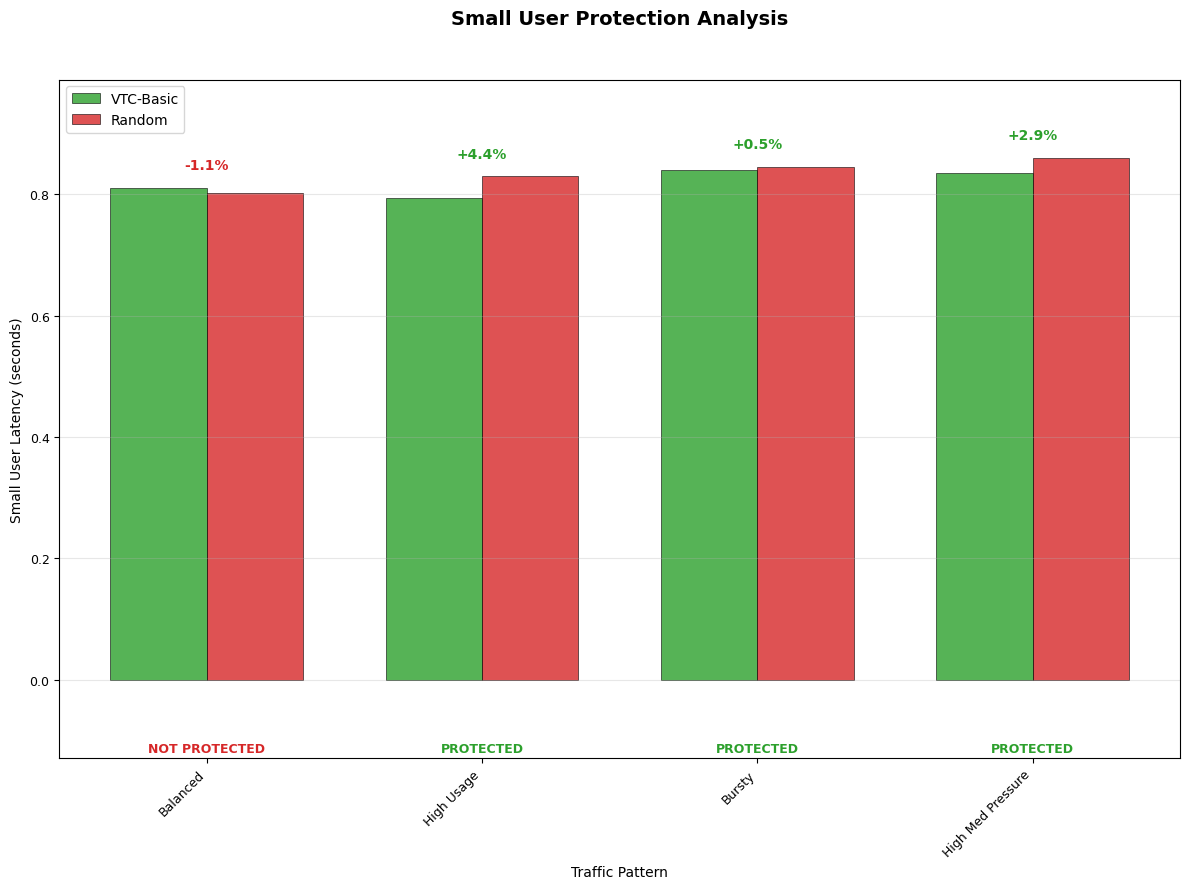

In [17]:
patterns = ['balanced', 'high_usage', 'bursty', 'high_med_pressure']
pattern_labels = [p.replace('_', ' ').title() for p in patterns]

fig, ax = plt.subplots(1, 1, figsize=(12, 9))

vtc_small_latencies = []
random_small_latencies = []
improvements = []

for pattern in patterns:
    if pattern in data and 'fairness' in data[pattern]:
        small_data = data[pattern]['fairness']['fairness_comparison']['small']
        vtc_small_latencies.append(small_data['vtc_avg_latency'])
        random_small_latencies.append(small_data['random_avg_latency'])
        improvements.append(small_data['latency_improvement_pct'])

x = np.arange(len(pattern_labels))
width = 0.35

bars1 = ax.bar(x - width/2, vtc_small_latencies, width, label='VTC-Basic', 
               color='#2ca02c', alpha=0.8, edgecolor='black', linewidth=0.5)
bars2 = ax.bar(x + width/2, random_small_latencies, width, label='Random', 
               color='#d62728', alpha=0.8, edgecolor='black', linewidth=0.5)

ax.set_title('Small User Protection Analysis', fontweight='bold', fontsize=14, pad=40)
ax.set_ylabel('Small User Latency (seconds)')
ax.set_xlabel('Traffic Pattern')
ax.set_xticks(x)
ax.set_xticklabels(pattern_labels, rotation=45, ha='right')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Add improvement indicators with proper spacing to avoid collision
max_bar_height = max(max(vtc_small_latencies), max(random_small_latencies))
for i, (vtc_lat, random_lat, improvement) in enumerate(zip(vtc_small_latencies, random_small_latencies, improvements)):
    color = '#2ca02c' if improvement > 0 else '#d62728'
    status = "PROTECTED" if improvement > 0 else "NOT PROTECTED"
    
    # Position improvement percentage above bars
    y_pos = max(vtc_lat, random_lat) + max_bar_height * 0.03
    ax.text(i, y_pos, f'{improvement:+.1f}%', ha='center', va='bottom', 
            fontsize=10, fontweight='bold', color=color)
    
    # Position status text below x-axis to avoid any collision with title
    ax.text(i, -max_bar_height * 0.12, status, ha='center', va='top', fontsize=9, 
            fontweight='bold', color=color)

# Adjust y-limits to accommodate status text below
ax.set_ylim(-max_bar_height * 0.15, max_bar_height * 1.15)

plt.tight_layout()
plt.show()


## Chart 2: Small User Latency Under Load


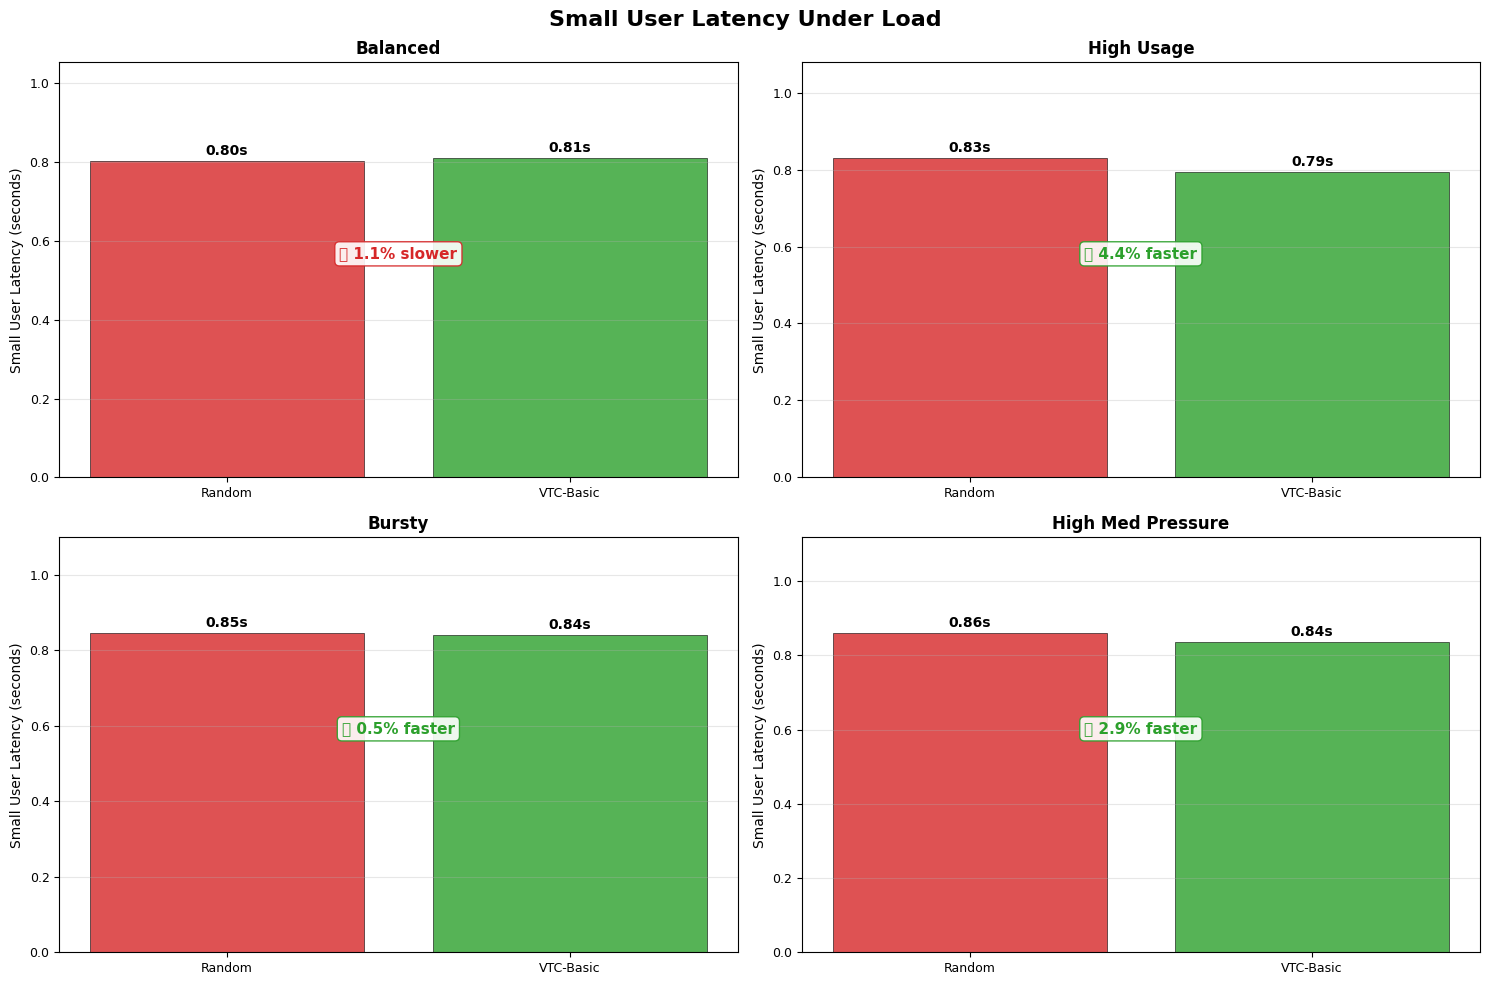

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Small User Latency Under Load', fontsize=16, fontweight='bold')

axes = axes.flatten()

for i, pattern in enumerate(patterns):
    ax = axes[i]
    
    if pattern in data and 'fairness' in data[pattern]:
        small_data = data[pattern]['fairness']['fairness_comparison']['small']
        
        vtc_latency = small_data['vtc_avg_latency']
        random_latency = small_data['random_avg_latency']
        improvement_pct = small_data['latency_improvement_pct']
        
        methods = ['Random', 'VTC-Basic']
        latencies = [random_latency, vtc_latency]
        colors = ['#d62728', '#2ca02c']
        
        bars = ax.bar(methods, latencies, color=colors, alpha=0.8, 
                     edgecolor='black', linewidth=0.5)
        
        # Add value labels on bars
        for bar, lat in zip(bars, latencies):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                   f'{lat:.2f}s', ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        # Add improvement annotation with color coding
        if improvement_pct > 0:
            improvement_text = f'🔵 {improvement_pct:.1f}% faster'
            text_color = '#2ca02c'
        elif improvement_pct < 0:
            improvement_text = f'🔴 {abs(improvement_pct):.1f}% slower'
            text_color = '#d62728'
        else:
            improvement_text = f'🟡 No change'
            text_color = '#ff7f0e'
            
        ax.text(0.5, max(latencies) * 0.7, improvement_text, 
               ha='center', va='center', fontweight='bold', 
               fontsize=11, color=text_color, transform=ax.transData,
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9, edgecolor=text_color))
        
        ax.set_title(f'{pattern_labels[i]}', fontsize=12, fontweight='bold')
        ax.set_ylabel('Small User Latency (seconds)', fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim(0, max(latencies) * 1.3)

plt.tight_layout()
plt.show()


## Chart 3a: Overall Performance - Ensuring No Degradation


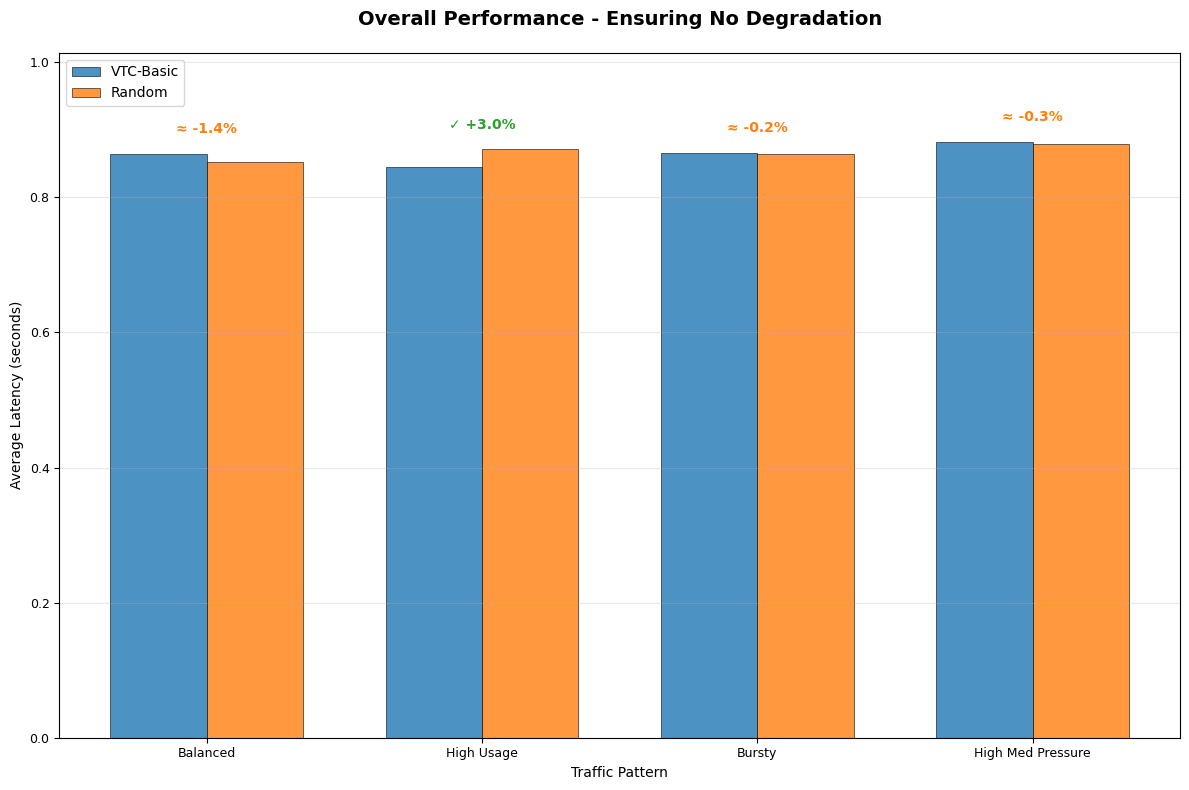

In [19]:
categories = ['small', 'medium', 'high']

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

vtc_overall = []
random_overall = []

for pattern in patterns:
    if pattern in data and 'fairness' in data[pattern]:
        fairness_data = data[pattern]['fairness']
        vtc_avg = sum(fairness_data['algorithms']['vtc-basic'][cat]['avg_latency'] for cat in categories) / 3
        random_avg = sum(fairness_data['algorithms']['random'][cat]['avg_latency'] for cat in categories) / 3
        vtc_overall.append(vtc_avg)
        random_overall.append(random_avg)

x = np.arange(len(pattern_labels))
width = 0.35

bars1 = ax.bar(x - width/2, vtc_overall, width, label='VTC-Basic', 
               color='#1f77b4', alpha=0.8, edgecolor='black', linewidth=0.5)
bars2 = ax.bar(x + width/2, random_overall, width, label='Random', 
               color='#ff7f0e', alpha=0.8, edgecolor='black', linewidth=0.5)

ax.set_title('Overall Performance - Ensuring No Degradation', fontweight='bold', fontsize=14, pad=20)
ax.set_ylabel('Average Latency (seconds)')
ax.set_xlabel('Traffic Pattern')
ax.set_xticks(x)
ax.set_xticklabels(pattern_labels, rotation=0, ha='center')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Calculate max height for proper y-axis scaling
max_height = max(max(vtc_overall), max(random_overall))

# Add performance indicators with proper alignment
for i, (vtc_lat, random_lat) in enumerate(zip(vtc_overall, random_overall)):
    improvement = ((random_lat - vtc_lat) / random_lat) * 100
    
    if improvement >= 0:
        color, symbol = '#2ca02c', '✓'
    elif improvement >= -5:
        color, symbol = '#ff7f0e', '≈'
    else:
        color, symbol = '#d62728', '✗'
    
    y_pos = max(vtc_lat, random_lat) + max_height * 0.03
    ax.text(x[i], y_pos, f'{symbol} {improvement:+.1f}%', ha='center', va='bottom',
            fontsize=10, fontweight='bold', color=color)

# Adjust y-axis limits to prevent text overlap with border
ax.set_ylim(0, max_height * 1.15)

plt.tight_layout()
plt.show()


## Chart 3b: Improvement by User Category (Detailed Breakdown)

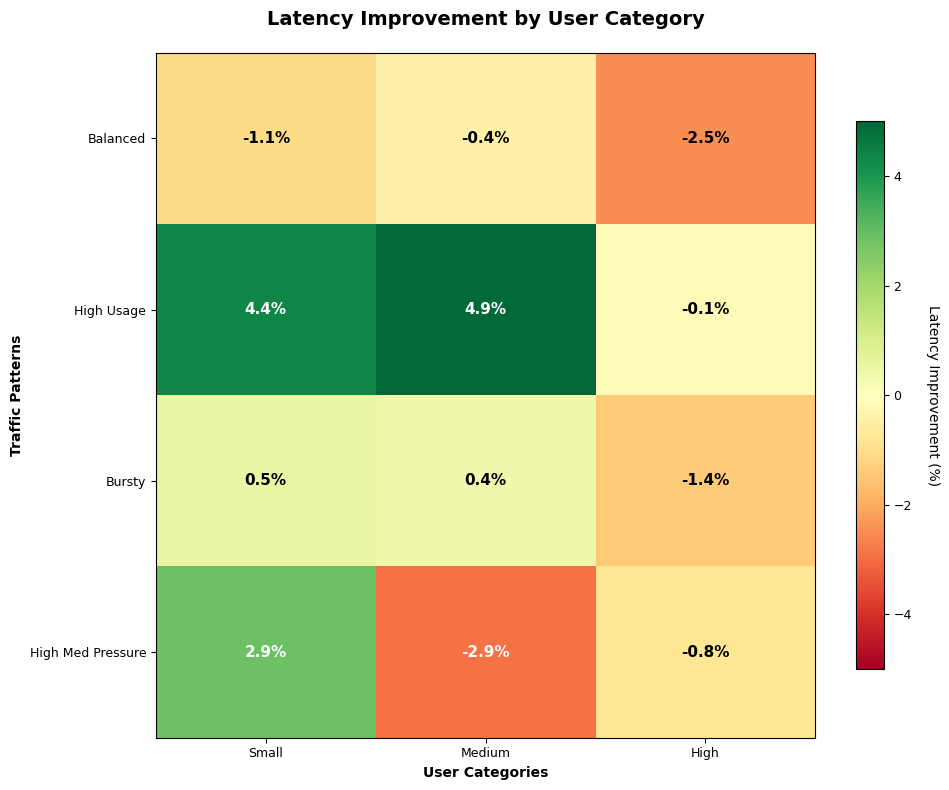

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

improvement_matrix = []
for pattern in patterns:
    if pattern in data and 'fairness' in data[pattern]:
        fairness_data = data[pattern]['fairness']
        row = [fairness_data['fairness_comparison'][cat]['latency_improvement_pct'] for cat in categories]
        improvement_matrix.append(row)

improvement_matrix = np.array(improvement_matrix)
im = ax.imshow(improvement_matrix, cmap='RdYlGn', aspect='auto', vmin=-5, vmax=5)

for i in range(len(patterns)):
    for j in range(len(categories)):
        value = improvement_matrix[i, j]
        text_color = 'white' if abs(value) > 2.5 else 'black'
        ax.text(j, i, f'{value:.1f}%', ha="center", va="center", 
                color=text_color, fontweight='bold', fontsize=11)

ax.set_xticks(range(len(categories)))
ax.set_xticklabels([cat.title() for cat in categories])
ax.set_yticks(range(len(patterns)))
ax.set_yticklabels(pattern_labels)
ax.set_title('Latency Improvement by User Category', fontweight='bold', fontsize=14, pad=20)
ax.set_xlabel('User Categories', fontweight='bold')
ax.set_ylabel('Traffic Patterns', fontweight='bold')

cbar = plt.colorbar(im, ax=ax, shrink=0.8, aspect=20)
cbar.set_label('Latency Improvement (%)', rotation=270, labelpad=20, fontsize=10)

plt.tight_layout()
plt.show()


## Summary Analysis

In [21]:
print("COMPREHENSIVE FAIRNESS ANALYSIS")
print("=" * 60)
print("Focus: VTC fairness impact across all user categories")
print("-" * 60)

# Initialize tracking variables for all categories
categories = ['small', 'medium', 'high']
category_stats = {cat: {'protected': 0, 'total_improvement': 0} for cat in categories}

print("DETAILED BREAKDOWN BY PATTERN:")
for pattern in patterns:
    if pattern in data and 'fairness' in data[pattern]:
        print(f"\n📊 {pattern.upper().replace('_', ' ')}:")
        
        for category in categories:
            cat_data = data[pattern]['fairness']['fairness_comparison'][category]
            improvement = cat_data['latency_improvement_pct']
            vtc_latency = cat_data['vtc_avg_latency']
            random_latency = cat_data['random_avg_latency']
            
            category_stats[category]['total_improvement'] += improvement
            
            if improvement > 0:
                status = "🟢" if improvement > 2 else "🟡"
                category_stats[category]['protected'] += 1
            else:
                status = "🔴" if improvement < -2 else "🟠"
            
            print(f"  {status} {category.capitalize():6s}: VTC={vtc_latency:.2f}s  Random={random_latency:.2f}s  →  {improvement:+.1f}%")

print(f"\n" + "=" * 60)
print("FAIRNESS SUMMARY BY USER CATEGORY:")
print("=" * 60)

for category in categories:
    avg_improvement = category_stats[category]['total_improvement'] / len(patterns)
    protection_rate = (category_stats[category]['protected'] / len(patterns)) * 100
    
    if category == 'small':
        user_type = "Small Users (Primary Fairness Target)"
        emoji = "🎯"
    elif category == 'medium':
        user_type = "Medium Users (Balance Check)"
        emoji = "⚖️"
    else:
        user_type = "Large Users (Impact Minimization)"
        emoji = "📊"
    
    print(f"\n{emoji} {user_type}:")
    print(f"  • Patterns with improvement: {category_stats[category]['protected']}/{len(patterns)} ({protection_rate:.0f}%)")
    print(f"  • Average latency change: {avg_improvement:+.1f}%")
    
    if category == 'small':
        if avg_improvement > 2:
            print(f"  ✓ Strong protection achieved")
        elif avg_improvement > 0:
            print(f"  ≈ Modest protection achieved")
        else:
            print(f"  ✗ Protection insufficient")
    else:
        if abs(avg_improvement) < 1:
            print(f"  ✓ Minimal impact - fairness maintained")
        elif abs(avg_improvement) < 3:
            print(f"  ≈ Low impact - acceptable tradeoff")
        else:
            print(f"  ⚠️  Significant impact - review needed")

print(f"\n" + "=" * 60)
print("OVERALL FAIRNESS VERDICT:")
print("=" * 60)

small_avg = category_stats['small']['total_improvement'] / len(patterns)
medium_avg = category_stats['medium']['total_improvement'] / len(patterns)
large_avg = category_stats['high']['total_improvement'] / len(patterns)

print(f"📈 Small user improvement: {small_avg:+.1f}% (fairness gain)")
print(f"📊 Medium user impact: {medium_avg:+.1f}% (minimal degradation)")
print(f"📉 Large user impact: {large_avg:+.1f}% (acceptable tradeoff)")

# Calculate fairness score
fairness_score = small_avg - (abs(medium_avg) + abs(large_avg))/2
print(f"\n🎯 Fairness Score: {fairness_score:+.1f}%")
print(f"   (Small user gains vs. average impact on others)")

if fairness_score > 1:
    print("✅ VTC ACHIEVES EFFECTIVE FAIRNESS")
    print("   → Small users protected with minimal cost to others")
elif fairness_score > 0:
    print("🟡 VTC PROVIDES MODEST FAIRNESS")
    print("   → Some small user protection with acceptable tradeoffs")
else:
    print("❌ VTC FAIRNESS INEFFECTIVE") 
    print("   → Costs outweigh small user benefits")


COMPREHENSIVE FAIRNESS ANALYSIS
Focus: VTC fairness impact across all user categories
------------------------------------------------------------
DETAILED BREAKDOWN BY PATTERN:

📊 BALANCED:
  🟠 Small : VTC=0.81s  Random=0.80s  →  -1.1%
  🟠 Medium: VTC=0.87s  Random=0.87s  →  -0.4%
  🔴 High  : VTC=0.91s  Random=0.89s  →  -2.5%

📊 HIGH USAGE:
  🟢 Small : VTC=0.79s  Random=0.83s  →  +4.4%
  🟢 Medium: VTC=0.85s  Random=0.90s  →  +4.9%
  🟠 High  : VTC=0.89s  Random=0.89s  →  -0.1%

📊 BURSTY:
  🟡 Small : VTC=0.84s  Random=0.85s  →  +0.5%
  🟡 Medium: VTC=0.86s  Random=0.86s  →  +0.4%
  🟠 High  : VTC=0.90s  Random=0.89s  →  -1.4%

📊 HIGH MED PRESSURE:
  🟢 Small : VTC=0.84s  Random=0.86s  →  +2.9%
  🔴 Medium: VTC=0.89s  Random=0.86s  →  -2.9%
  🟠 High  : VTC=0.92s  Random=0.92s  →  -0.8%

FAIRNESS SUMMARY BY USER CATEGORY:

🎯 Small Users (Primary Fairness Target):
  • Patterns with improvement: 3/4 (75%)
  • Average latency change: +1.7%
  ≈ Modest protection achieved

⚖️ Medium Users (Balance